In [6]:
%pylab inline

import glob
import matplotlib.pyplot as plt
import numexpr
import os
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Preparing the data

## Data loading and putting it into a suitable format

### Parsing chord labels to binary pitch class sets

- for chord label dataset
- [x] see `tools/add_pitch_class_sets.sh`

### Joining DataFrames from each album and track into a common DataFrame

### Loading key labels and cleaning them

- silence/key
- [x] just root pitch class
- [x] convert minor keys to parallel majors
- [x] take care of trash such as `D:dorian`

## Data sanity checks

- in each segment the end time is greater than the start time
- the start time of each segment is greater or equal than the end time of previous segment
- key segments are aligned with chord segments
- the files for each song should match between chords and keys
  - each chord and key file should span the same time interval
    - ie. end time of last chord and key segment in a song should be equal

## Features for key classification

- for each chord segment row we need the key
- choose the length of a chord context
  - eg. 8 chords
    - with 12 pitch classes per row it makes a block of `12*16 = 192` columns per row
- split the dataset into blocks of adjacent chords and put each block into a wide row -> new dataframe

## Missing data

- `10CD2_-_The_Beatles/CD2_-_12_-_Revolution_9.lab` was missing in the original dataset
  - we added "silence" throughout the song instead
  - better would be to perform the actual annotation and add the right data

In [3]:
def impute_missing_key_files():
    path = 'data/beatles/keylab/The_Beatles/10CD2_-_The_Beatles/CD2_-_12_-_Revolution_9.lab'
    if not os.path.exists(path):
        df = pd.DataFrame.from_records(
            [("0.0", "502.204082", "Silence", None)],
            columns=['start', 'end', 'key_indicator', 'key_label'])
        df.to_csv(path, sep='\t', index=None, header=None)

impute_missing_key_files()

# Keys

In [4]:
files = glob.glob('data/beatles/keylab/The_Beatles/*/*.lab')
print('key files count:', len(files))
files

key files count: 180


['data/beatles/keylab/The_Beatles/01_-_Please_Please_Me/01_-_I_Saw_Her_Standing_There.lab',
 'data/beatles/keylab/The_Beatles/01_-_Please_Please_Me/02_-_Misery.lab',
 'data/beatles/keylab/The_Beatles/01_-_Please_Please_Me/03_-_Anna_(Go_To_Him).lab',
 'data/beatles/keylab/The_Beatles/01_-_Please_Please_Me/04_-_Chains.lab',
 'data/beatles/keylab/The_Beatles/01_-_Please_Please_Me/05_-_Boys.lab',
 'data/beatles/keylab/The_Beatles/01_-_Please_Please_Me/06_-_Ask_Me_Why.lab',
 'data/beatles/keylab/The_Beatles/01_-_Please_Please_Me/07_-_Please_Please_Me.lab',
 'data/beatles/keylab/The_Beatles/01_-_Please_Please_Me/08_-_Love_Me_Do.lab',
 'data/beatles/keylab/The_Beatles/01_-_Please_Please_Me/09_-_P._S._I_Love_You.lab',
 "data/beatles/keylab/The_Beatles/01_-_Please_Please_Me/10_-_Baby_It's_You.lab",
 'data/beatles/keylab/The_Beatles/01_-_Please_Please_Me/11_-_Do_You_Want_To_Know_A_Secret.lab',
 'data/beatles/keylab/The_Beatles/01_-_Please_Please_Me/12_-_A_Taste_Of_Honey.lab',
 "data/beatles/keyl

In [5]:
def read_key_file(path):
    return pd.read_csv(path, sep='\t', header=None, names=['start','end','key_indicator','key_label'])

In [6]:
read_key_file(files[0])

,start,end,key_indicator,key_label
0,0.000,1.035,Silence,NaN
1,1.035,171.880,Key,E
2,171.880,175.800,Silence,NaN


In [7]:
def add_track_id(df, track_id):
    df['track_id'] = track_id
    return df

In [8]:
keys = pd.concat(add_track_id(read_key_file(file), track_id) for (track_id, file) in enumerate(files))

In [9]:
keys

,start,end,key_indicator,key_label,track_id
0,0.000,1.035,Silence,NaN,0
1,1.035,171.880,Key,E,0
2,171.880,175.800,Silence,NaN,0
0,0.000,0.395,Silence,NaN,1
1,0.395,105.685,Key,C,1
2,105.685,110.160,Silence,NaN,1
0,0.000,0.410,Silence,NaN,2
1,0.410,174.120,Key,D,2
2,174.120,177.573,Silence,NaN,2
0,0.000,146.493,Key,Bb,3


In [10]:
keys['duration'] = keys['end'] - keys['start']

In [11]:
keys['key_label'].value_counts()

A               51
G               40
E               35
C               28
A:minor         25
D               25
F               13
E:minor         11
D:minor          9
C:minor          8
B                6
Eb               6
Bb               5
F:minor          5
C#:minor         4
F#:minor         2
G:mixolydian     2
Db               1
F:dorian         1
D:aeolian        1
A:mixolydian     1
C#:modal         1
F#               1
D:mixolydian     1
Eb:minor         1
Ab               1
dtype: int64

In [12]:
print('total number of key segments:', len(keys))

total number of key segments: 408


In [13]:
keys['duration'].describe()

count    408.000000
mean      71.893412
std       81.089744
min       -0.043000
25%        3.849000
50%       27.304000
75%      143.846750
max      502.204082
Name: duration, dtype: float64

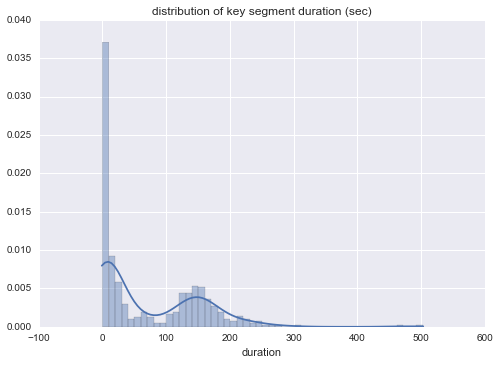

In [14]:
sns.distplot(keys['duration'], bins=50)
title('distribution of key segment duration (sec)');

In [15]:
keys['key_indicator'].value_counts()

Key        284
Silence    124
dtype: int64

In [16]:
# Total duration of segments with some key and with silence:
keys.groupby('key_indicator').sum()['duration']

key_indicator
Key              28589.011000
Silence            743.501082
Name: duration, dtype: float64

In [17]:
# The same in percentage:
keys.groupby('key_indicator').sum()['duration'] / keys['duration'].sum() * 100

key_indicator
Key              97.465266
Silence           2.534734
Name: duration, dtype: float64

Distribution of number of key segments among songs.

In [18]:
keys.groupby('track_id').count()['start'].describe()

count    180.000000
mean       2.266667
std        2.372091
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       18.000000
Name: start, dtype: float64

We need to map symbolic key labels to pitch classes. Since the label are not always referring to the diatonic key but sometimes to modes, we normalize the pitch class to represent the underlying diatonic key. This would help in our further classification since it reduces the number of classes and their meaning. In order key we can limit ourselves not to discriminate between modes.

In [19]:
diatonic_pitch_classes = {'C': 0, 'D': 2, 'E': 4, 'F': 5, 'G': 7, 'A': 9, 'B': 11}
accidental_shifts = {'': 0, 'b': -1, '#': 1}
mode_shifts = {
    '': 0,
    'major': 0,
    'ionian': 0,
    'dorian': -2,
    'phrygian': -4,
    'lydian': -5,
    'mixolydian': -7,
    'aeolian': -9,
    'minor': -9,
    'locrian': -11}

def tone_label_to_pitch_class(label):
    base = label[0].upper()
    pitch_class = diatonic_pitch_classes[base]
    accidental = label[1] if len(label) > 1 else ''
    shift = accidental_shifts[accidental]
    return ((pitch_class + shift) + 12) % 12

def diatonic_root_for_key_label(key_label):
    if type(key_label) is not str:
        return
    parts = key_label.split(':')
    modal_root_label = parts[0]
    modal_root_pitch_class = tone_label_to_pitch_class(modal_root_label)
    mode_label = parts[1].lower() if len(parts) > 1 else ''
    mode_shift = mode_shifts[mode_label] if mode_label in mode_shifts else 0
    diatonic_root = modal_root_pitch_class + mode_shift
#     return (modal_root_label, mode_label, modal_root_pitch_class, mode_shift, diatonic_root)
    return (diatonic_root + 12) % 12
    
unique_key_labels = list(keys['key_label'].value_counts().index)
[(label, diatonic_root_for_key_label(label)) for label in unique_key_labels]

[('A', 9),
 ('G', 7),
 ('E', 4),
 ('C', 0),
 ('A:minor', 0),
 ('D', 2),
 ('F', 5),
 ('E:minor', 7),
 ('D:minor', 5),
 ('C:minor', 3),
 ('B', 11),
 ('Eb', 3),
 ('Bb', 10),
 ('F:minor', 8),
 ('C#:minor', 4),
 ('F#:minor', 9),
 ('G:mixolydian', 0),
 ('Db', 1),
 ('F:dorian', 3),
 ('D:aeolian', 5),
 ('A:mixolydian', 2),
 ('C#:modal', 1),
 ('F#', 6),
 ('D:mixolydian', 7),
 ('Eb:minor', 6),
 ('Ab', 8)]

In [20]:
keys['key_diatonic_root'] = keys['key_label'].apply(diatonic_root_for_key_label)

In [21]:
canonic_pitch_class_labels = dict(enumerate(['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']))
def label_for_pitch_class(pc):
    if pc in canonic_pitch_class_labels:
        return canonic_pitch_class_labels[pc]

In [22]:
keys['key_diatonic_root_label'] = keys['key_diatonic_root'].apply(label_for_pitch_class)

In [23]:
diatonic_keys_hist = keys.dropna()['key_diatonic_root_label'].value_counts()
diatonic_keys_hist

C     55
A     53
G     52
E     39
D     26
F     23
Eb    15
B      6
Ab     6
Bb     5
Gb     2
Db     2
dtype: int64

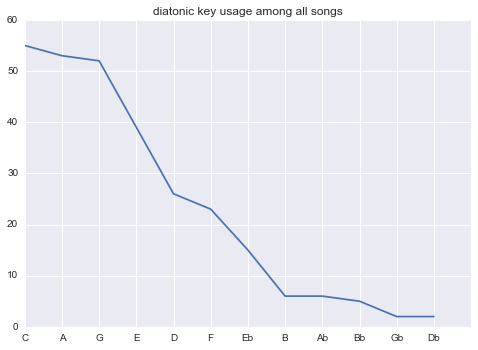

In [24]:
plot(diatonic_keys_hist)
xticks(np.arange(len(diatonic_keys_hist)), diatonic_keys_hist.index)
title('diatonic key usage among all songs');

In [25]:
# all tracks start at 0.0 time
assert (keys.groupby('track_id').first()['start'] == 0).all()

# duration of each segment should be positive
# assert (keys.groupby('track_id')['duration'] < 0).all()

In [26]:
keys.groupby('track_id').last()['end']

track_id
0           175.800
1           110.160
2           177.573
3           146.493
4           147.507
5           147.760
6           123.373
7           142.760
8           125.733
9           158.067
10          119.333
11          125.133
12          112.867
13          153.267
14          133.733
...
165          96.867
166         139.827
167          23.267
168         216.667
169         234.800
170         228.560
171         145.733
172          50.000
173         243.307
174          40.600
175         217.960
176         175.507
177         217.867
178         152.733
179         187.093
Name: end, Length: 180, dtype: float64

In [27]:
keys

,start,end,key_indicator,key_label,track_id,duration,key_diatonic_root,key_diatonic_root_label
0,0.000,1.035,Silence,NaN,0,1.035,NaN,None
1,1.035,171.880,Key,E,0,170.845,4,E
2,171.880,175.800,Silence,NaN,0,3.920,NaN,None
0,0.000,0.395,Silence,NaN,1,0.395,NaN,None
1,0.395,105.685,Key,C,1,105.290,0,C
2,105.685,110.160,Silence,NaN,1,4.475,NaN,None
0,0.000,0.410,Silence,NaN,2,0.410,NaN,None
1,0.410,174.120,Key,D,2,173.710,2,D
2,174.120,177.573,Silence,NaN,2,3.453,NaN,None
0,0.000,146.493,Key,Bb,3,146.493,10,Bb


Export the prepared DataFrame to TSV file.

In [28]:
keys = keys[[
        'track_id', 'start', 'end', 'duration', 'key_indicator',
        'key_label', 'key_diatonic_root_label', 'key_diatonic_root']]

In [29]:
keys.to_csv('data/beatles/derived/all_keys.tsv', sep='\t', index=False, float_format='%.3f')

## Chords

In [30]:
files = glob.glob('data/beatles/chordlab/The_Beatles/*/*.lab.pcs.tsv')
print('chord files count:', len(files))
files

chord files count: 180


['data/beatles/chordlab/The_Beatles/01_-_Please_Please_Me/01_-_I_Saw_Her_Standing_There.lab.pcs.tsv',
 'data/beatles/chordlab/The_Beatles/01_-_Please_Please_Me/02_-_Misery.lab.pcs.tsv',
 'data/beatles/chordlab/The_Beatles/01_-_Please_Please_Me/03_-_Anna_(Go_To_Him).lab.pcs.tsv',
 'data/beatles/chordlab/The_Beatles/01_-_Please_Please_Me/04_-_Chains.lab.pcs.tsv',
 'data/beatles/chordlab/The_Beatles/01_-_Please_Please_Me/05_-_Boys.lab.pcs.tsv',
 'data/beatles/chordlab/The_Beatles/01_-_Please_Please_Me/06_-_Ask_Me_Why.lab.pcs.tsv',
 'data/beatles/chordlab/The_Beatles/01_-_Please_Please_Me/07_-_Please_Please_Me.lab.pcs.tsv',
 'data/beatles/chordlab/The_Beatles/01_-_Please_Please_Me/08_-_Love_Me_Do.lab.pcs.tsv',
 'data/beatles/chordlab/The_Beatles/01_-_Please_Please_Me/09_-_P._S._I_Love_You.lab.pcs.tsv',
 "data/beatles/chordlab/The_Beatles/01_-_Please_Please_Me/10_-_Baby_It's_You.lab.pcs.tsv",
 'data/beatles/chordlab/The_Beatles/01_-_Please_Please_Me/11_-_Do_You_Want_To_Know_A_Secret.lab.pcs

In [31]:
def read_chord_file(path):
    return pd.read_csv(path, sep=' ', header=None, names=['start','end','chord_label'])

def read_chord_file_with_pitch_classes(path):
    return pd.read_csv(path, sep='\t')

In [32]:
read_chord_file_with_pitch_classes(files[0])

,start,end,label,root,bass,C,Db,D,Eb,E,F,Gb,G,Ab,A,Bb,B
0,0.000000,2.612267,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2.612267,11.459070,E,4,4,0,0,0,0,1,0,0,0,1,0,0,1
2,11.459070,12.921927,A,9,9,0,1,0,0,1,0,0,0,0,1,0,0
3,12.921927,17.443474,E,4,4,0,0,0,0,1,0,0,0,1,0,0,1
4,17.443474,20.410362,B,11,11,0,0,0,1,0,0,1,0,0,0,0,1
5,20.410362,21.908049,E,4,4,0,0,0,0,1,0,0,0,1,0,0,1
6,21.908049,23.370907,E:7/3,4,8,0,0,1,0,1,0,0,0,1,0,0,1
7,23.370907,24.856984,A,9,9,0,1,0,0,1,0,0,0,0,1,0,0
8,24.856984,26.343061,A:min/b3,9,0,1,0,0,0,1,0,0,0,0,1,0,0
9,26.343061,27.840748,E,4,4,0,0,0,0,1,0,0,0,1,0,0,1


In [33]:
chords = pd.concat(add_track_id(read_chord_file_with_pitch_classes(file), track_id) for (track_id, file) in enumerate(files))

In [34]:
chords['duration'] = chords['end'] - chords['start']

In [35]:
chords = chords.reindex_axis(['track_id', 'start', 'end', 'duration', 'label', 'root', 'bass', 'C','Db','D','Eb','E','F','Gb','G','Ab','A','Bb','B'], axis=1)
chords

,track_id,start,end,duration,label,root,bass,C,Db,D,Eb,E,F,Gb,G,Ab,A,Bb,B
0,0,0.000000,2.612267,2.612267,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2.612267,11.459070,8.846803,E,4,4,0,0,0,0,1,0,0,0,1,0,0,1
2,0,11.459070,12.921927,1.462857,A,9,9,0,1,0,0,1,0,0,0,0,1,0,0
3,0,12.921927,17.443474,4.521547,E,4,4,0,0,0,0,1,0,0,0,1,0,0,1
4,0,17.443474,20.410362,2.966888,B,11,11,0,0,0,1,0,0,1,0,0,0,0,1
5,0,20.410362,21.908049,1.497687,E,4,4,0,0,0,0,1,0,0,0,1,0,0,1
6,0,21.908049,23.370907,1.462858,E:7/3,4,8,0,0,1,0,1,0,0,0,1,0,0,1
7,0,23.370907,24.856984,1.486077,A,9,9,0,1,0,0,1,0,0,0,0,1,0,0
8,0,24.856984,26.343061,1.486077,A:min/b3,9,0,1,0,0,0,1,0,0,0,0,1,0,0
9,0,26.343061,27.840748,1.497687,E,4,4,0,0,0,0,1,0,0,0,1,0,0,1


In [36]:
# all tracks start at 0.0 time
assert (chords.groupby('track_id').first()['start'] == 0).all()

### Chords vs. keys - alignment

In [37]:
chords_keys_end_diff = chords.groupby('track_id').last()[['end']].rename(columns={'end': 'chords_end'}).join(keys.groupby('track_id').last()[['end']].rename(columns={'end': 'keys_end'}))
chords_keys_end_diff['diff'] = chords_keys_end_diff['chords_end'] - chords_keys_end_diff['keys_end']

In [38]:
chords_keys_end_diff['diff'].describe()

count    180.000000
mean       0.005191
std        0.035198
min       -0.133061
25%        0.005714
50%        0.014663
75%        0.020469
max        0.039245
Name: diff, dtype: float64

Track lengths are not precisely aligned between chords and keys dataset. Roughly they're are alrigth, however.

In [39]:
chords_keys_end_diff

,chords_end,keys_end,diff
track_id,,,
0,175.804082,175.800,0.004082
1,110.184490,110.160,0.024490
2,177.580408,177.573,0.007408
3,146.494694,146.493,0.001694
4,147.513469,147.507,0.006469
5,147.774694,147.760,0.014694
6,123.376327,123.373,0.003327
7,142.759184,142.760,-0.000816
8,125.753469,125.733,0.020469


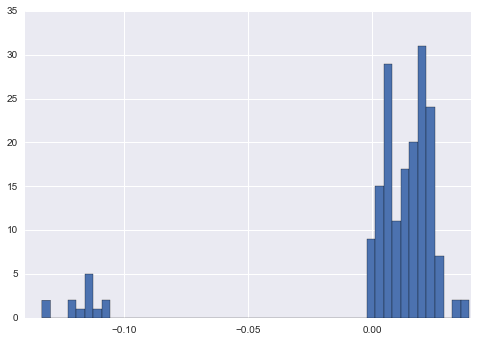

In [40]:
chords_keys_end_diff['diff'].hist(bins=50);

### Merge chords and keys 

In [41]:
chords.head()

,track_id,start,end,duration,label,root,bass,C,Db,D,Eb,E,F,Gb,G,Ab,A,Bb,B
0,0,0.000000,2.612267,2.612267,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2.612267,11.459070,8.846803,E,4,4,0,0,0,0,1,0,0,0,1,0,0,1
2,0,11.459070,12.921927,1.462857,A,9,9,0,1,0,0,1,0,0,0,0,1,0,0
3,0,12.921927,17.443474,4.521547,E,4,4,0,0,0,0,1,0,0,0,1,0,0,1
4,0,17.443474,20.410362,2.966888,B,11,11,0,0,0,1,0,0,1,0,0,0,0,1


In [42]:
keys.head()

,track_id,start,end,duration,key_indicator,key_label,key_diatonic_root_label,key_diatonic_root
0,0,0.000,1.035,1.035,Silence,NaN,None,NaN
1,0,1.035,171.880,170.845,Key,E,E,4
2,0,171.880,175.800,3.920,Silence,NaN,None,NaN
0,1,0.000,0.395,0.395,Silence,NaN,None,NaN
1,1,0.395,105.685,105.290,Key,C,C,0


Let's try to merge keys to chords from a single example track.

In [43]:
track_keys = keys[keys['track_id'] == 109]
track_keys

,track_id,start,end,duration,key_indicator,key_label,key_diatonic_root_label,key_diatonic_root
0,109,0.000,135.830,135.830,Key,G,G,7
1,109,135.830,198.310,62.480,Key,E,E,4
2,109,198.310,259.226,60.916,Key,G,G,7
3,109,259.226,333.907,74.681,Key,E,E,4
4,109,333.907,333.907,0.000,Silence,NaN,None,NaN


In [44]:
track_chords = chords[chords['track_id'] == 109]
track_chords

,track_id,start,end,duration,label,root,bass,C,Db,D,Eb,E,F,Gb,G,Ab,A,Bb,B
0,109,0.000000,1.914761,1.914761,G,7,7,0,0,1,0,0,0,0,1,0,0,0,1
1,109,1.914761,3.369980,1.455219,B:min,11,11,0,0,1,0,0,0,1,0,0,0,0,1
2,109,3.369980,6.519569,3.149589,E:min7,4,4,0,0,1,0,1,0,0,1,0,0,0,1
3,109,6.519569,12.848047,6.328478,C,0,0,1,0,0,0,1,0,0,1,0,0,0,0
4,109,12.848047,14.425963,1.577916,G,7,7,0,0,1,0,0,0,0,1,0,0,0,1
5,109,14.425963,15.923650,1.497687,B:min/5,11,6,0,0,1,0,0,0,1,0,0,0,0,1
6,109,15.923650,17.490997,1.567347,E:min7,4,4,0,0,1,0,1,0,0,1,0,0,0,1
7,109,17.490997,18.988684,1.497687,E:min7/b7,4,2,0,0,1,0,1,0,0,1,0,0,0,1
8,109,18.988684,20.556031,1.567347,C,0,0,1,0,0,0,1,0,0,1,0,0,0,0
9,109,20.556031,22.123378,1.567347,E:min/5,4,11,0,0,0,0,1,0,0,1,0,0,0,1


In [27]:
def plot_time_intervals(starts, ends, **kwargs):
    x_lines = [el for (s, e) in zip(starts, ends) for el in (s, e, None)]
    y_lines = [el for i in range(len(starts)) for el in (i, i, None)]
    plot(x_lines, y_lines, **kwargs)

def plot_chords_and_keys(track_chords, track_keys):
    plot_time_intervals(track_chords['start'], track_chords['end'], label='chord segments')
    plot_time_intervals(track_keys['start'], track_keys['end'], label='key segments')
    title('chord and key segments in time')
    legend(loc='center right')
    xlabel('time (sec)')
    ylabel('segment index')

In [ ]:
plot_chords_and_keys(track_chords, track_keys);

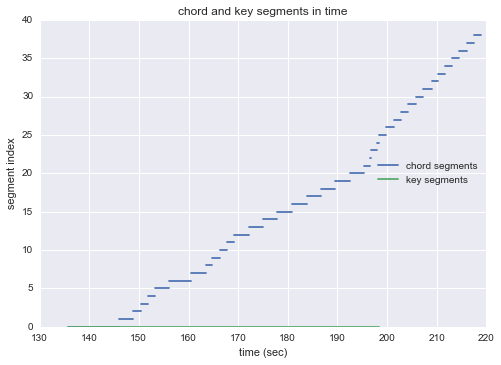

In [46]:
def time_range(df, start, end):
    return df[(df['start'] >= start) & (df['end'] <= end)]

plot_chords_and_keys(time_range(track_chords, 120, 220), time_range(track_keys, 120, 220))

In [47]:
def find_key(keys, track_id, start):
    "Finds the first key segment within a track that the chord segment spans."
    possible_keys = keys.query('(start <= '+str(start)+') & (track_id == '+str(track_id)+')')
    if len(possible_keys) > 0:
        row = possible_keys.iloc[-1]
#         return pd.Series([start, ['start']])
        return row

find_key(keys, 109, 198.0)

track_id                      109
start                      135.83
end                        198.31
duration                    62.48
key_indicator                 Key
key_label                       E
key_diatonic_root_label         E
key_diatonic_root               4
Name: 1, dtype: object

In [48]:
track_chords['start'].apply(lambda start: find_key(track_keys, 109, start)[['key_diatonic_root_label', 'key_diatonic_root']])

,key_diatonic_root_label,key_diatonic_root
0,G,7
1,G,7
2,G,7
3,G,7
4,G,7
5,G,7
6,G,7
7,G,7
8,G,7
9,G,7


In [49]:
track_keys

,track_id,start,end,duration,key_indicator,key_label,key_diatonic_root_label,key_diatonic_root
0,109,0.000,135.830,135.830,Key,G,G,7
1,109,135.830,198.310,62.480,Key,E,E,4
2,109,198.310,259.226,60.916,Key,G,G,7
3,109,259.226,333.907,74.681,Key,E,E,4
4,109,333.907,333.907,0.000,Silence,NaN,None,NaN


In [50]:
track_chords

,track_id,start,end,duration,label,root,bass,C,Db,D,Eb,E,F,Gb,G,Ab,A,Bb,B
0,109,0.000000,1.914761,1.914761,G,7,7,0,0,1,0,0,0,0,1,0,0,0,1
1,109,1.914761,3.369980,1.455219,B:min,11,11,0,0,1,0,0,0,1,0,0,0,0,1
2,109,3.369980,6.519569,3.149589,E:min7,4,4,0,0,1,0,1,0,0,1,0,0,0,1
3,109,6.519569,12.848047,6.328478,C,0,0,1,0,0,0,1,0,0,1,0,0,0,0
4,109,12.848047,14.425963,1.577916,G,7,7,0,0,1,0,0,0,0,1,0,0,0,1
5,109,14.425963,15.923650,1.497687,B:min/5,11,6,0,0,1,0,0,0,1,0,0,0,0,1
6,109,15.923650,17.490997,1.567347,E:min7,4,4,0,0,1,0,1,0,0,1,0,0,0,1
7,109,17.490997,18.988684,1.497687,E:min7/b7,4,2,0,0,1,0,1,0,0,1,0,0,0,1
8,109,18.988684,20.556031,1.567347,C,0,0,1,0,0,0,1,0,0,1,0,0,0,0
9,109,20.556031,22.123378,1.567347,E:min/5,4,11,0,0,0,0,1,0,0,1,0,0,0,1


In [51]:
chord = chords.iloc[0]
keys_for_track = keys[keys['track_id'] == chord.track_id]
keys_for_track[keys_for_track['start'] >= chord['start']]

,track_id,start,end,duration,key_indicator,key_label,key_diatonic_root_label,key_diatonic_root
0,0,0.000,1.035,1.035,Silence,NaN,None,NaN
1,0,1.035,171.880,170.845,Key,E,E,4
2,0,171.880,175.800,3.920,Silence,NaN,None,NaN


In [52]:
# this is very inefficient, it takes many seconds
# TODO: optimize this!
key_labels_for_chords = chords[['track_id','start']].apply(
    lambda row: find_key(keys, row['track_id'], row['start']),
    axis=1)[['key_diatonic_root_label', 'key_diatonic_root']]

In [53]:
key_labels_for_chords[:10]

,key_diatonic_root_label,key_diatonic_root
0,None,NaN
1,E,4
2,E,4
3,E,4
4,E,4
5,E,4
6,E,4
7,E,4
8,E,4
9,E,4


Append the computed key for each chord segment.

In [54]:
for col in ('key_diatonic_root_label', 'key_diatonic_root'):
    chords[col] = key_labels_for_chords[col]

In [55]:
chords

,track_id,start,end,duration,label,root,bass,C,Db,D,...,E,F,Gb,G,Ab,A,Bb,B,key_diatonic_root_label,key_diatonic_root
0,0,0.000000,2.612267,2.612267,N,0,0,0,0,0,...,0,0,0,0,0,0,0,0,None,NaN
1,0,2.612267,11.459070,8.846803,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4
2,0,11.459070,12.921927,1.462857,A,9,9,0,1,0,...,1,0,0,0,0,1,0,0,E,4
3,0,12.921927,17.443474,4.521547,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4
4,0,17.443474,20.410362,2.966888,B,11,11,0,0,0,...,0,0,1,0,0,0,0,1,E,4
5,0,20.410362,21.908049,1.497687,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4
6,0,21.908049,23.370907,1.462858,E:7/3,4,8,0,0,1,...,1,0,0,0,1,0,0,1,E,4
7,0,23.370907,24.856984,1.486077,A,9,9,0,1,0,...,1,0,0,0,0,1,0,0,E,4
8,0,24.856984,26.343061,1.486077,A:min/b3,9,0,1,0,0,...,1,0,0,0,0,1,0,0,E,4
9,0,26.343061,27.840748,1.497687,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4


Key distribution in chord segments.

In [56]:
chords.key_diatonic_root_label.value_counts()

G     2916
A     2528
E     2221
C     2198
D     1928
F      983
B      491
Eb     446
Bb     274
Gb     184
Ab     182
Db      90
dtype: int64

In [57]:
chords.to_csv('data/beatles/derived/all_chords_with_keys.tsv', sep='\t', index=False, float_format='%.6f')

We can see that the key labels are heavily skewed and this might not be good for our ML models.

In order to deskew the class distribution we can generate more data from the existing data by transposing each data point to all 12 keys. This way we'll have a 12x larger dataset and uniform classes.

In [58]:
chords.head()

,track_id,start,end,duration,label,root,bass,C,Db,D,...,E,F,Gb,G,Ab,A,Bb,B,key_diatonic_root_label,key_diatonic_root
0,0,0.000000,2.612267,2.612267,N,0,0,0,0,0,...,0,0,0,0,0,0,0,0,None,NaN
1,0,2.612267,11.459070,8.846803,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4
2,0,11.459070,12.921927,1.462857,A,9,9,0,1,0,...,1,0,0,0,0,1,0,0,E,4
3,0,12.921927,17.443474,4.521547,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4
4,0,17.443474,20.410362,2.966888,B,11,11,0,0,0,...,0,0,1,0,0,0,0,1,E,4


In [139]:
def add_pitch_classes(a, b):
    return ((a + b) + 12) % 12

def rotate_columns(cols, shift):
    return cols[shift:] + cols[:shift]

pcs_columns = ['C','Db','D','Eb','E','F','Gb','G','Ab','A','Bb','B']

[rotate_columns(pcs_columns, i) for i in range(12)]

[['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B'],
 ['Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B', 'C'],
 ['D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B', 'C', 'Db'],
 ['Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B', 'C', 'Db', 'D'],
 ['E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb'],
 ['F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb', 'E'],
 ['Gb', 'G', 'Ab', 'A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb', 'E', 'F'],
 ['G', 'Ab', 'A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb'],
 ['Ab', 'A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G'],
 ['A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab'],
 ['Bb', 'B', 'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A'],
 ['B', 'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb']]

In [84]:
def rotate_binary_pcs_cols(df, cols, shift):
    return df.rename_axis(dict(zip(cols, rotate_columns(cols, shift))), axis=1)
    
rotate_binary_pcs_cols(chords, pcs_columns, 2)[pcs_columns].head()

,C,Db,D,Eb,E,F,Gb,G,Ab,A,Bb,B
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,1,0
2,0,0,0,1,0,0,1,0,0,0,0,1
3,0,1,0,0,0,0,1,0,0,0,1,0
4,0,1,0,0,0,1,0,0,1,0,0,0


In [61]:
chords[pcs_columns].head()

,C,Db,D,Eb,E,F,Gb,G,Ab,A,Bb,B
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,0,1
2,0,1,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,1,0,0,1
4,0,0,0,1,0,0,1,0,0,0,0,1


In [62]:
def transpose_col(df, shift):
    return df.apply(lambda pc: add_pitch_classes(pc, shift))

transpose_col(chords[['root', 'bass', 'key_diatonic_root']], 11).head()

,root,bass,key_diatonic_root
0,11,11,NaN
1,3,3,3
2,8,8,3
3,3,3,3
4,10,10,3


In [63]:
def transpose_chords_df(chords, shift):
    chords_copy = chords.copy()
    chords_copy['synth_transposition'] = shift
    pc_cols = ['root', 'bass', 'key_diatonic_root']
    chords_copy[pc_cols] = transpose_col(chords_copy[pc_cols], shift)
    chords_copy['key_diatonic_root_label'] = chords_copy['key_diatonic_root'].apply(label_for_pitch_class)
    chords_copy = rotate_binary_pcs_cols(chords_copy, pcs_columns, shift)
    chords_copy = chords_copy.rename_axis({'label': 'orig_chord_label'}, axis=1)
    return chords_copy

transpose_chords_df(chords, 1).head()

,track_id,start,end,duration,orig_chord_label,root,bass,Db,D,Eb,...,Gb,G,Ab,A,Bb,B,C,key_diatonic_root_label,key_diatonic_root,synth_transposition
0,0,0.000000,2.612267,2.612267,N,1,1,0,0,0,...,0,0,0,0,0,0,0,None,NaN,1
1,0,2.612267,11.459070,8.846803,E,5,5,0,0,0,...,0,0,0,1,0,0,1,F,5,1
2,0,11.459070,12.921927,1.462857,A,10,10,0,1,0,...,0,0,0,0,1,0,0,F,5,1
3,0,12.921927,17.443474,4.521547,E,5,5,0,0,0,...,0,0,0,1,0,0,1,F,5,1
4,0,17.443474,20.410362,2.966888,B,0,0,0,0,0,...,0,1,0,0,0,0,1,F,5,1


In [93]:
def generate_transpositions(chords):
    df = pd.concat([transpose_chords_df(chords, shift) for shift in range(12)])
    df = df[['track_id', 'synth_transposition',
             'start', 'end', 'duration',
             'orig_chord_label', 'root', 'bass',
             'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B',
             'key_diatonic_root_label', 'key_diatonic_root']]
    return df

In [94]:
chords_all_synth = generate_transpositions(chords)

In [95]:
chords_all_synth.columns

Index(['track_id', 'synth_transposition', 'start', 'end', 'duration', 'orig_chord_label', 'root', 'bass', 'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B', 'key_diatonic_root_label', 'key_diatonic_root'], dtype='object')

In [96]:
len(chords_all_synth)

175452

All key classes are now of uniform probability.

In [97]:
chords_all_synth['key_diatonic_root'].value_counts()

11    14441
10    14441
9     14441
8     14441
7     14441
6     14441
5     14441
4     14441
3     14441
2     14441
1     14441
0     14441
dtype: int64

In [98]:
chords_all_synth[pcs_columns].mean()

C     0.257164
Db    0.257164
D     0.257164
Eb    0.257164
E     0.257164
F     0.257164
Gb    0.257164
G     0.257164
Ab    0.257164
A     0.257164
Bb    0.257164
B     0.257164
dtype: float64

In [99]:
chords_all_synth.head()

,track_id,synth_transposition,start,end,duration,orig_chord_label,root,bass,C,Db,...,E,F,Gb,G,Ab,A,Bb,B,key_diatonic_root_label,key_diatonic_root
0,0,0,0.000000,2.612267,2.612267,N,0,0,0,0,...,0,0,0,0,0,0,0,0,None,NaN
1,0,0,2.612267,11.459070,8.846803,E,4,4,0,0,...,1,0,0,0,1,0,0,1,E,4
2,0,0,11.459070,12.921927,1.462857,A,9,9,0,1,...,1,0,0,0,0,1,0,0,E,4
3,0,0,12.921927,17.443474,4.521547,E,4,4,0,0,...,1,0,0,0,1,0,0,1,E,4
4,0,0,17.443474,20.410362,2.966888,B,11,11,0,0,...,0,0,1,0,0,0,0,1,E,4


In [100]:
chords_all_synth[abs(chords_all_synth['start'] - 2.612267) < 1e-3]

,track_id,synth_transposition,start,end,duration,orig_chord_label,root,bass,C,Db,...,E,F,Gb,G,Ab,A,Bb,B,key_diatonic_root_label,key_diatonic_root
1,0,0,2.612267,11.45907,8.846803,E,4,4,0,0,...,1,0,0,0,1,0,0,1,E,4
1,0,1,2.612267,11.45907,8.846803,E,5,5,1,0,...,0,1,0,0,0,1,0,0,F,5
1,0,2,2.612267,11.45907,8.846803,E,6,6,0,1,...,0,0,1,0,0,0,1,0,Gb,6
1,0,3,2.612267,11.45907,8.846803,E,7,7,0,0,...,0,0,0,1,0,0,0,1,G,7
1,0,4,2.612267,11.45907,8.846803,E,8,8,1,0,...,0,0,0,0,1,0,0,0,Ab,8
1,0,5,2.612267,11.45907,8.846803,E,9,9,0,1,...,1,0,0,0,0,1,0,0,A,9
1,0,6,2.612267,11.45907,8.846803,E,10,10,0,0,...,0,1,0,0,0,0,1,0,Bb,10
1,0,7,2.612267,11.45907,8.846803,E,11,11,0,0,...,0,0,1,0,0,0,0,1,B,11
1,0,8,2.612267,11.45907,8.846803,E,0,0,1,0,...,1,0,0,1,0,0,0,0,C,0
1,0,9,2.612267,11.45907,8.846803,E,1,1,0,1,...,0,1,0,0,1,0,0,0,Db,1


In [101]:
chords_all_synth.to_csv('data/beatles/derived/all_chords_with_keys_synth.tsv', sep='\t', index=False, float_format='%.6f')

## Chord sequences

In [247]:
chords_all = pd.read_csv('data/beatles/derived/all_chords_with_keys.tsv', sep='\t')
chords_all_synth = pd.read_csv('data/beatles/derived/all_chords_with_keys_synth.tsv', sep='\t')

In [248]:
chords_all = chords_all.dropna()
chords_all_synth = chords_all_synth.dropna()
chords_all.head()

,track_id,start,end,duration,label,root,bass,C,Db,D,...,E,F,Gb,G,Ab,A,Bb,B,key_diatonic_root_label,key_diatonic_root
1,0,2.612267,11.459070,8.846803,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4
2,0,11.459070,12.921927,1.462857,A,9,9,0,1,0,...,1,0,0,0,0,1,0,0,E,4
3,0,12.921927,17.443474,4.521547,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4
4,0,17.443474,20.410362,2.966888,B,11,11,0,0,0,...,0,0,1,0,0,0,0,1,E,4
5,0,20.410362,21.908049,1.497687,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4


In [98]:
track_chords = chords_all[(chords_all['track_id'] == 40)].copy()
track_chords.head(10)

,track_id,start,end,duration,label,root,bass,C,Db,D,...,F,Gb,G,Ab,A,Bb,B,key_diatonic_root_label,key_diatonic_root,key_index
2976,40,0.000000,0.421247,0.421247,N,0,0,0,0,0,...,0,0,0,0,0,0,0,A,9,53
2977,40,0.421247,1.148857,0.727610,"F#:(1,4,b7)",6,6,0,0,0,...,0,1,0,0,0,0,1,A,9,53
2978,40,1.148857,4.997527,3.848670,A,9,9,0,1,0,...,0,0,0,0,1,0,0,A,9,53
2979,40,4.997527,7.053628,2.056101,A:min,9,9,1,0,0,...,0,0,0,0,1,0,0,A,9,53
2980,40,7.053628,8.899614,1.845986,G,7,7,0,0,1,...,0,0,1,0,0,0,1,C,0,54
2981,40,8.899614,10.873310,1.973696,F,5,5,1,0,0,...,1,0,0,0,1,0,0,C,0,54
2982,40,10.873310,12.742517,1.869207,E,4,4,0,0,0,...,0,0,0,1,0,0,1,C,0,54
2983,40,12.742517,16.538979,3.796462,A,9,9,0,1,0,...,0,0,0,0,1,0,0,C,0,54
2984,40,16.538979,18.477845,1.938866,A:min,9,9,1,0,0,...,0,0,0,0,1,0,0,A,9,55
2985,40,18.477845,20.347052,1.869207,G,7,7,0,0,1,...,0,0,1,0,0,0,1,C,0,56


In [62]:
chords_all['key_index'] = ((chords_all['key_diatonic_root'].diff() != 0) | (chords_all['track_id'].diff() != 0)).cumsum()

In [63]:
chords_all

,track_id,start,end,duration,label,root,bass,C,Db,D,...,F,Gb,G,Ab,A,Bb,B,key_diatonic_root_label,key_diatonic_root,key_index
1,0,2.612267,11.459070,8.846803,E,4,4,0,0,0,...,0,0,0,1,0,0,1,E,4,1
2,0,11.459070,12.921927,1.462857,A,9,9,0,1,0,...,0,0,0,0,1,0,0,E,4,1
3,0,12.921927,17.443474,4.521547,E,4,4,0,0,0,...,0,0,0,1,0,0,1,E,4,1
4,0,17.443474,20.410362,2.966888,B,11,11,0,0,0,...,0,1,0,0,0,0,1,E,4,1
5,0,20.410362,21.908049,1.497687,E,4,4,0,0,0,...,0,0,0,1,0,0,1,E,4,1
6,0,21.908049,23.370907,1.462858,E:7/3,4,8,0,0,1,...,0,0,0,1,0,0,1,E,4,1
7,0,23.370907,24.856984,1.486077,A,9,9,0,1,0,...,0,0,0,0,1,0,0,E,4,1
8,0,24.856984,26.343061,1.486077,A:min/b3,9,0,1,0,0,...,0,0,0,0,1,0,0,E,4,1
9,0,26.343061,27.840748,1.497687,E,4,4,0,0,0,...,0,0,0,1,0,0,1,E,4,1
10,0,27.840748,29.350045,1.509297,B,11,11,0,0,0,...,0,1,0,0,0,0,1,E,4,1


In [96]:
# track_chords.groupby(['track_id']).last()['key_index']
(chords_all.groupby(['track_id', 'key_index']).count()['start'] > 16).mean()

0.76305220883534142

In [222]:
c = chords_all[:200]
c

,track_id,start,end,duration,label,root,bass,C,Db,D,...,F,Gb,G,Ab,A,Bb,B,key_diatonic_root_label,key_diatonic_root,key_index
1,0,2.612267,11.459070,8.846803,E,4,4,0,0,0,...,0,0,0,1,0,0,1,E,4,1
2,0,11.459070,12.921927,1.462857,A,9,9,0,1,0,...,0,0,0,0,1,0,0,E,4,1
3,0,12.921927,17.443474,4.521547,E,4,4,0,0,0,...,0,0,0,1,0,0,1,E,4,1
4,0,17.443474,20.410362,2.966888,B,11,11,0,0,0,...,0,1,0,0,0,0,1,E,4,1
5,0,20.410362,21.908049,1.497687,E,4,4,0,0,0,...,0,0,0,1,0,0,1,E,4,1
6,0,21.908049,23.370907,1.462858,E:7/3,4,8,0,0,1,...,0,0,0,1,0,0,1,E,4,1
7,0,23.370907,24.856984,1.486077,A,9,9,0,1,0,...,0,0,0,0,1,0,0,E,4,1
8,0,24.856984,26.343061,1.486077,A:min/b3,9,0,1,0,0,...,0,0,0,0,1,0,0,E,4,1
9,0,26.343061,27.840748,1.497687,E,4,4,0,0,0,...,0,0,0,1,0,0,1,E,4,1
10,0,27.840748,29.350045,1.509297,B,11,11,0,0,0,...,0,1,0,0,0,0,1,E,4,1


In [217]:
def pcs_block_cols(block_size):
    return ['%s_%02d'%(pc, i) for i in range(block_size) for pc in pcs_columns]

def block_columns(block_size): 
    return pcs_block_cols(block_size) + ['key_diatonic_root']

def merge_chord_block(block_df):
    all_pcs = block_df.as_matrix(columns=pcs_columns).ravel()
    most_frequent_key = block_df['key_diatonic_root'].value_counts().index[0]
    return np.hstack([all_pcs, most_frequent_key])

In [252]:
def roll_chords(chords_df, window_size=4):
    blocks = (chords_df.iloc[start:start+window_size] for start in range(len(chords_df) - window_size + 1))
    c_rolling = (merge_chord_block(block) for block in blocks)
    df_rolling = pd.DataFrame(c_rolling, columns=block_columns(window_size)).astype(np.int16)
    return df_rolling

Generate data points by reshaping input rows in the rolling window and selecting the most frequent output label. Do this for both original and synthetic data and for a different window sizes.

In [256]:
# TODO: optimize this, since it is not really efficient (~20 minutes for all the files...)

In [254]:
for postfix, chords in [('', chords_all), ('_synth', chords_all_synth)]:
    for window in (1,2,4,8,16):
        print('window:', window)
        chords_rolling = roll_chords(chords, window_size=window)
        print('shape:', chords_rolling.shape)
        chords_rolling.to_csv('data/beatles/derived/all_chords_with_keys'+postfix+'_rolling_'+str(window)+'.tsv', sep='\t', index=False)

window: 1
shape: (14441, 13)
window: 2
shape: (14440, 25)
window: 4
shape: (14438, 49)
window: 8
shape: (14434, 97)
window: 16
shape: (14426, 193)
window: 1
shape: (173292, 13)
window: 2
shape: (173291, 25)
window: 4
shape: (173289, 49)
window: 8
shape: (173285, 97)
window: 16
shape: (173277, 193)
